<a href="https://colab.research.google.com/github/aish-codes/karpathy_lectures/blob/main/makemore_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Makemore : Part 1

### Introduction

It'd be great if you have some understanding of neural network basics or have gone through the *[Neural Network : Zero to Hero](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)* series by Andrej Karpathy.  

This is a code first approach to recreate the lecture notebooks with some additional material for more clarity. The **pre-requisite** for this notebook are :
1. Python programming
2. Basic understanding of tensors and pytorch
3. High school calculus

Instead of using the names list provided by AK I used the words from the novel A Tale of Two Cities by Charles Dickens

In [137]:
# initiation
# read data from the g drive
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# names = open("/content/drive/MyDrive/Colab Notebooks/Karpathy Lectures/names.txt","r").read().splitlines()
# we're using text from a Tale of Two Cities as our input instead of names
words = open("/content/drive/MyDrive/Colab Notebooks/Karpathy Lectures/Tale of Two Cities.txt").read()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
# data cleansing
# removing unwanted words and getting it in a similar order to how it's done in the video
import re
words = words.lower() # converted text to lower case
words_list = words.split(" ") # split on the basis of spaces
words_list_filtered = [re.sub(r'[^a-zA-Z]', '', w) for w in words_list] #remove every special character
words_list_filtered = [w for w in words_list_filtered if w != ''] # removing empty words

In [139]:
# initialize dict
b = {} # this is our character level dictionary that we'd use everywhere going forward
for w in words_list_filtered :
  chs = ["."] + list(w) + ["."]
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

b_flat = sorted(set([ch for bigram in b.keys() for ch in bigram]))

In [140]:
# creating a dict assigning each word an integer
wtoi = {w:i for i,w in enumerate(b_flat)} #
wtoi['.'] = 0

# reversed logic
itow = {i:w for w,i in wtoi.items()}

### What has happened so far?

1. Instead of using a unique name list we have used words from the novel A Tale of Two Cities.
2. We are trying to build a bigram model which uses the previous character/letter to predict the next letter
3. Because of point 1. there is a high probability that you'll see the repetition of prepositions like 'the', 'on', etc while doing word generations
4. In wtoi we have built up a dictionary assigning a number to each letter
5. Read [this](https://docs.pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html) before moving ahead

In [141]:
# initializing a tensor. if you're reading then try and answer why did we initialize it with a 27 x 27 matrix
import torch
torch.set_printoptions(precision=4,sci_mode=False)
N = torch.zeros((27,27), dtype=torch.int32)

# storing combination of each letter with the other for example aa, ab, ac & so on
for w in words_list_filtered :
  chs = ["."] + list(w) + ["."]
  for ix1, ix2 in zip(chs, chs[1:]):
    ix1 = wtoi[ix1]
    ix2 = wtoi[ix2]
    N[ix1, ix2] += 1

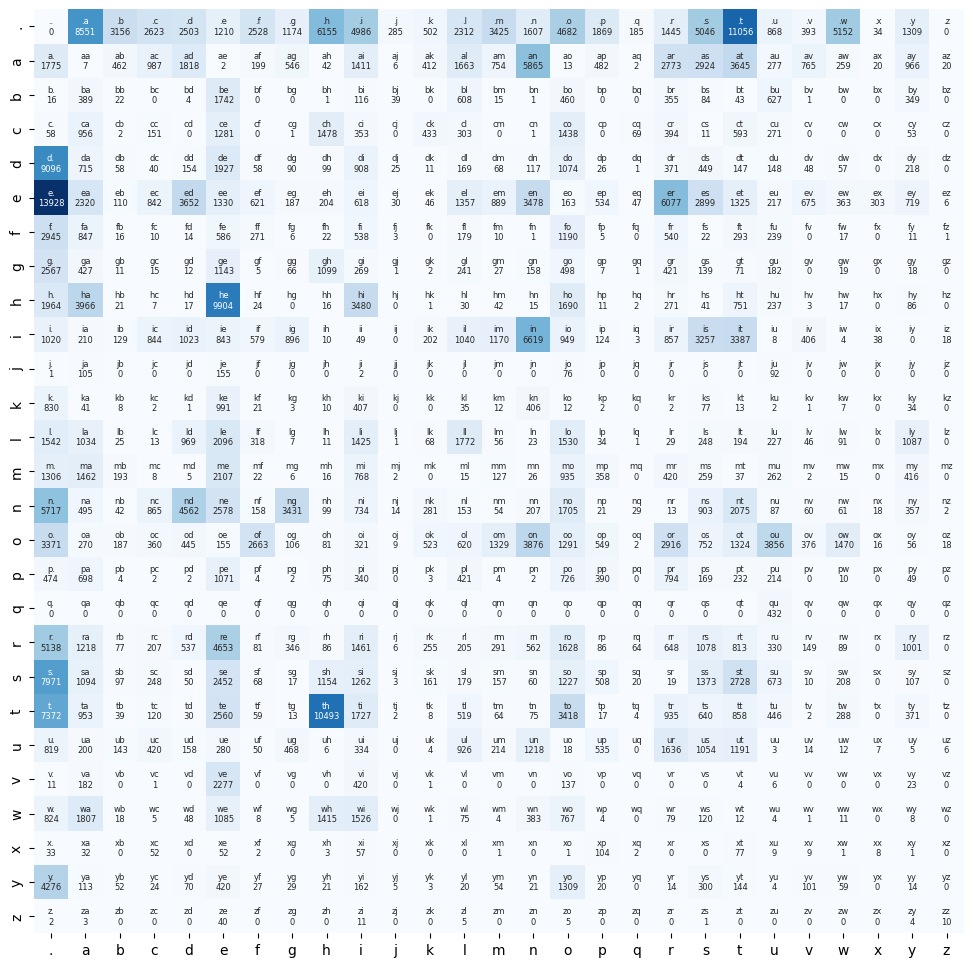

In [142]:
# visualizing N
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Build a matrix of strings like "ab\n123"
annot_matrix = np.empty_like(N, dtype=object)
for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        word = itow[i] + itow[j]   # bigram
        annot_matrix[i, j] = f"{word}\n{N[i, j].item()}"  # combination + count

plt.figure(figsize=(12,12))
sns.heatmap(
    N,
    annot=annot_matrix,  # custom annotation matrix
    fmt="",              # fmt="" since we already format text
    cmap="Blues",
    cbar=False,
    xticklabels=[itow[i] for i in range(N.shape[1])],
    yticklabels=[itow[i] for i in range(N.shape[0])],
    annot_kws={"size":6}
)
plt.show()

### So why did we create that N for?

1. In order to build a character level bigram model we need to calculate probabilities of each character occuring after a character
2. With N we have a matrix of 27 x 27 with combination of each letter with the other and their occurences

In [143]:
# Generating words based on our matrix N
# This is a very crude bigram language model
# import library
import random

# pick a random starting index
n = random.randint(1, 26)
g = torch.Generator() # removed maual seed otherwise it was generating same words again and again

for _ in range(10):   # generate 10 random words
    word = []
    n = wtoi["."]   # always start from start token i.e. '.'
    while True:
        p = N[n].float()
        p /= p.sum()  # normalize
        ix = torch.multinomial(p, num_samples=1, replacement=True).item() # special torch fn for generating samples where p represents probabilities and it randomly picks a number
        letter = itow[ix]

        if letter == '.':   # end of word
            break

        word.append(letter)
        n = ix  # move to next state

    print(''.join(word)) # should produce absolute gutter atm

cisere
wak
tithinte
watothe
an
knchay
r
aghormus
couthednder
uecrouee


This seems to give a very good intuitive understanding of how tensor broadcasting works. Read more [here](https://docs.pytorch.org/docs/stable/notes/broadcasting.html)

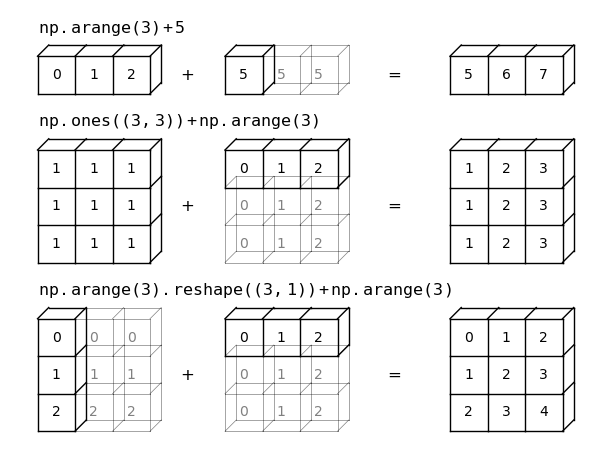

## What should be an ideal bigram model?

1. The best model would be certain in terms of its output of what comes next, i.e. the probability should be 1 fot he next letter.
2. Models are trained to minimize *loss functions* and we create a function to measure our model's capability. **We calculate the log of the probability of the combination of letters based on N**
3. The average negative of the this log likelihood is then used as our metric to measure our model performance


In [144]:
# sample function for understanding
# optimizing the loss function over
P = N.float()
P /= P.sum(1,keepdims = True) # probability distribution for each letter combination
log_likelihood, n = 0, 0 # initialize

for w in words_list_filtered[:5] : # using sample of 5 words
  w = ["."] + list(w) + ["."]
  for ch1, ch2 in zip(w, w[1:]) :
    ix1 = wtoi[ch1]
    ix2 = wtoi[ch2]
    p = P[ix1, ix2]
    log_likelihood += torch.log(p)
    n += 1

nll = -log_likelihood # negative log likelihood
print(f'log likelihood = {log_likelihood}')
print(f'negative log likelihood = {nll}')
print(f'average negative log likelihood = {nll/n}')

log likelihood = -86.25836181640625
negative log likelihood = 86.25836181640625
average negative log likelihood = 2.7825276851654053


## Implementing in pytorch

We created a sample code which we would reuse below to recreate with torch. Moving forward we will build a neural network with layers to predict the next letter and eventually build words that make sense.

In [145]:
# implementing the above using torch now
xs, ys = [], []

for w in words_list_filtered:
  w = ["."] + list(w) + ["."]
  for ch1, ch2 in zip(w, w[1:]):
    ix1 = wtoi[ch1]
    ix2 = wtoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

# here we have a mapping of x with y i.e. input and expected output where all letters are encoded by letters
xs, ys = torch.tensor(xs), torch.tensor(ys)

In [146]:
import torch.nn.functional as F # for using ohe function
from torch import Generator

# forwards pass example
xenc = F.one_hot(xs, num_classes = 27).float() # using one hot encoding function to identify the letter
g = Generator().manual_seed(123)
W  = torch.randn((27, 27),generator = g, requires_grad=True) # initializing weights for layer 1

# view xenc to understand ohe
# xenc[1,:]

In [147]:
# initialize learning rate
lr = 10 # play around with it to lower it even further

# importing library for calculating time taken to train the model
import time
start_time = time.time()

for _ in range(1000):
  # Doing the matmul
  logits = xenc @ W # [419720, 27] x [27, 27] =  [419720, 27]
  N = logits.exp() # exponentiating because mul with W might've resulted in neg values and we want probabilities in the next step
  probs = N/N.sum(dim = 1, keepdims = True)
  ys = torch.tensor(ys, dtype=torch.long)   # ensure tensor type
  loss = -probs[torch.arange(xs.shape[0]), ys].log().mean()

  # backward pass
  W.grad =  None # setting it up to 0 for every loop
  loss.backward() # backpropogation

  print(f'The nll is {loss}')

  W.data += -lr * W.grad

end_time = time.time()
final_time = end_time - start_time
print(f'The model took {final_time} seconds to run and the final loss nll is {loss}')

/tmp/ipython-input-2264714876.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = torch.tensor(ys, dtype=torch.long)   # ensure tensor type


The nll is 3.6920411586761475
The nll is 3.6024105548858643
The nll is 3.521516799926758
The nll is 3.4481465816497803
The nll is 3.3814632892608643
The nll is 3.3207874298095703
The nll is 3.26550555229187
The nll is 3.2150418758392334
The nll is 3.1688642501831055
The nll is 3.126497745513916
The nll is 3.0875282287597656
The nll is 3.0516011714935303
The nll is 3.018413782119751
The nll is 2.9877066612243652
The nll is 2.959258556365967
The nll is 2.932874917984009
The nll is 2.908385753631592
The nll is 2.8856379985809326
The nll is 2.864492416381836
The nll is 2.844820976257324
The nll is 2.8265020847320557
The nll is 2.809422254562378
The nll is 2.793473958969116
The nll is 2.7785556316375732
The nll is 2.764573812484741
The nll is 2.7514419555664062
The nll is 2.7390811443328857
The nll is 2.727421283721924
The nll is 2.7163989543914795
The nll is 2.7059578895568848
The nll is 2.6960484981536865
The nll is 2.686627149581909
The nll is 2.677654981613159
The nll is 2.6690983772277

## Final results

In [148]:
# generating words
# the above model can be optimized even more but we're sticking to it for the time being
for _ in range(10):   # generate 10 words
    word = []
    n = wtoi["."]   # start token

    while True:
        # one-hot encode current token
        xenc = F.one_hot(torch.tensor([n]), num_classes=27).float()
        logits = xenc @ W              # shape (1, 27)
        probs = logits.softmax(dim=1)  # turn into probabilities

        # sample next index
        ix = torch.multinomial(probs[0], num_samples=1).item()
        letter = itow[ix]

        if letter == ".":
            break

        word.append(letter)
        n = ix  # feed back as next input

    print("".join(word))


t

o
ibuzzpen
lanste
devpon
be
tem
lives
heroofu


Holy cow ! Something works but not blown away. It gives out the same trashy predictions because it's built with the same initial logics just implemented in pytorch. We've added a layer to measure our model performance and optimize its performance. However, concerns remain

1. The problem with our current generation is that there is data leakage as we haven't divided our data into test and train

2. Another issue with our current model is that it is difficult to scale if we want to move from bigram to let's say sentence formation

# Buidling Makemore : Part 2

The earlier code piece would act as a building block in this part where we're building up using [this paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

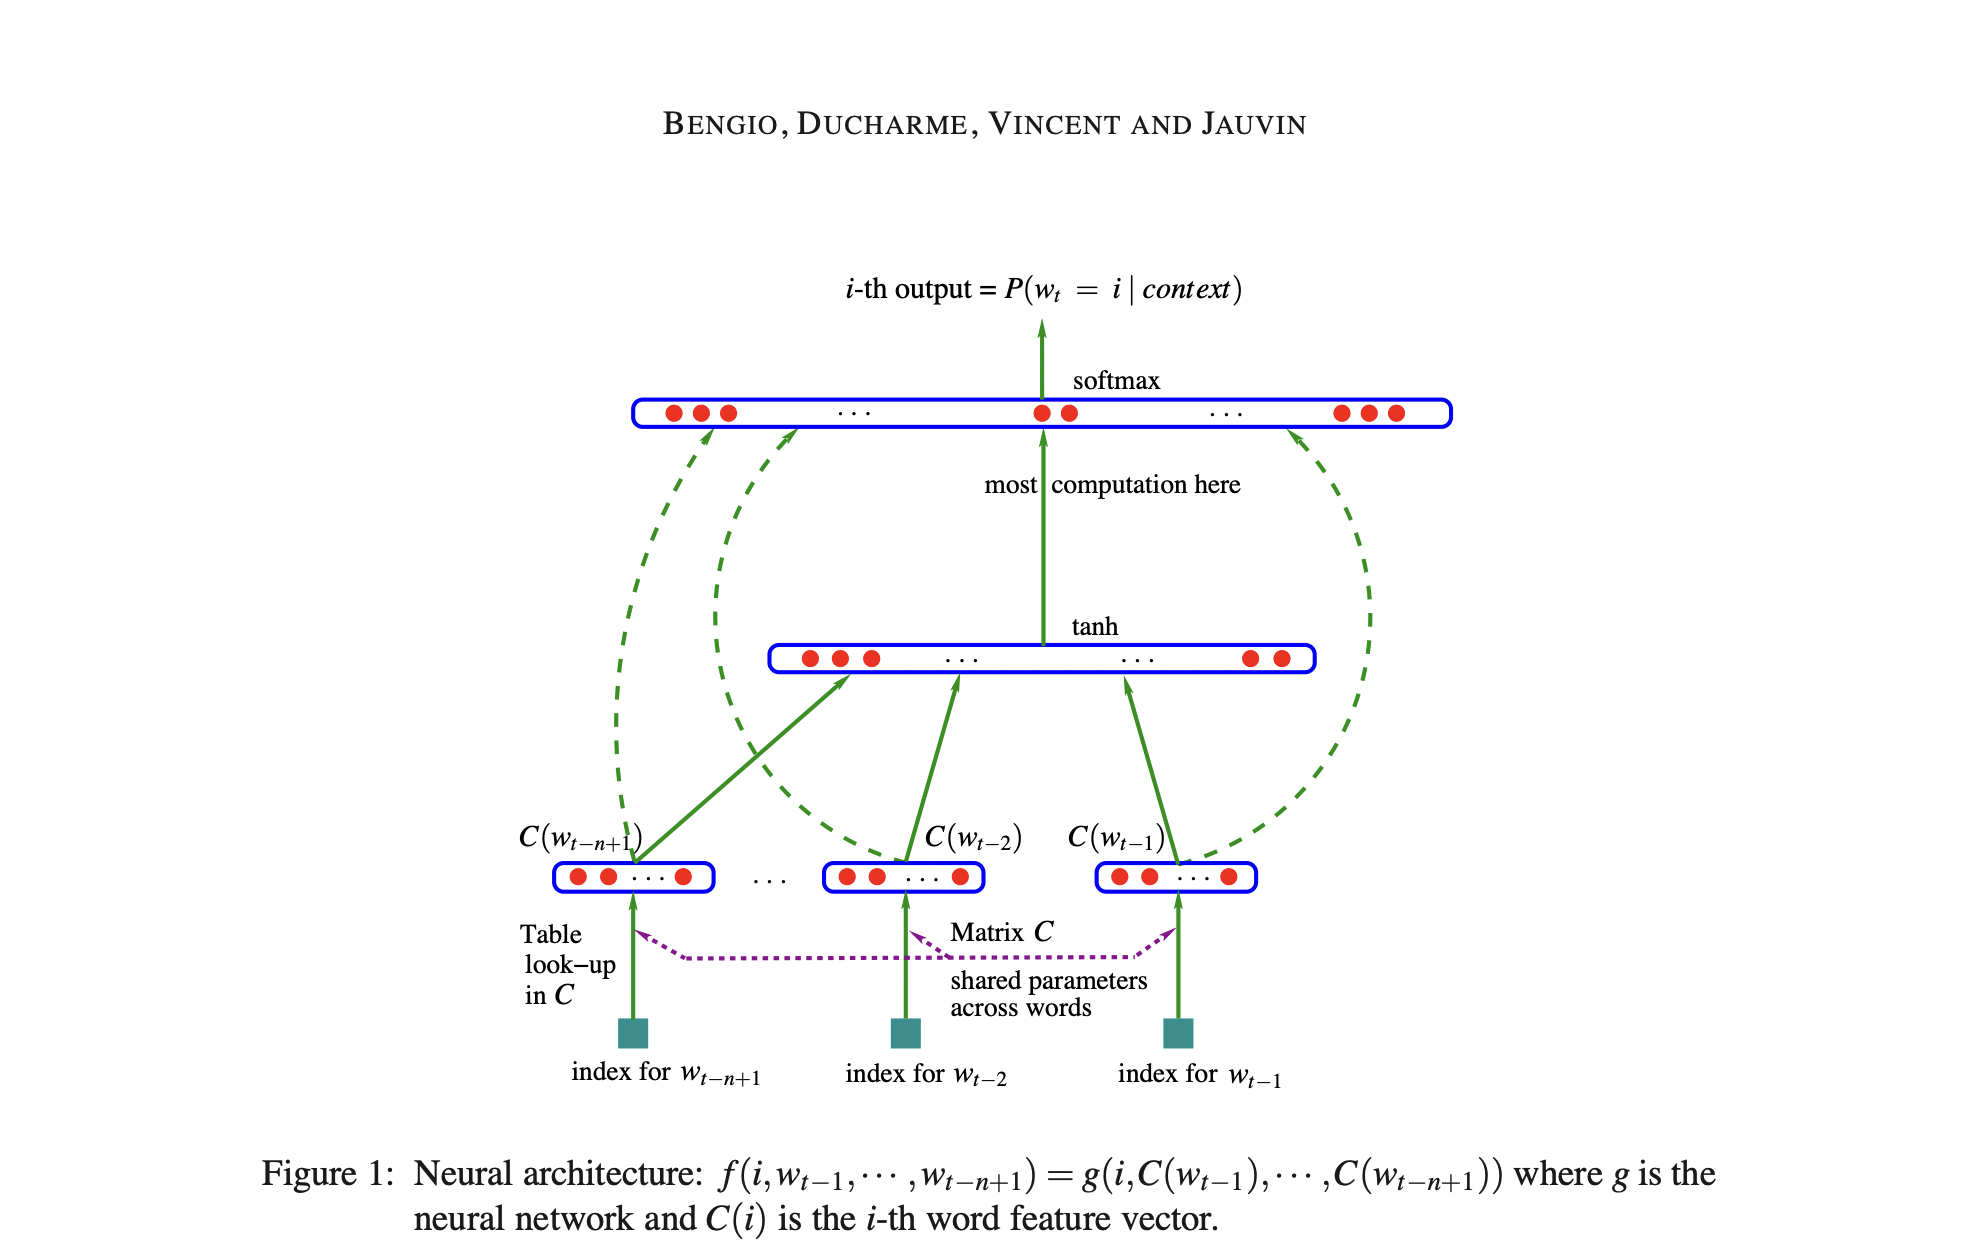

### What now?

The issues with our earlier code pice as I have highlighted earlier is that the cost to scale it would be very high. Hence we've decided to use a multi layer perceptron to train our current model with higher context lengths

We would follow the below steps
1. increase context length from 2 to 5
2. we drop the N bigram probability matrix
3. encode our input
4. add a layer of weights *(W)* and bias *(b)*
5. pass ouput of 3rd pointer through a softmax func like tanh to generate probabilities for next character
6. instead of training the data on the whole dataset we'd use **mini batches** for updating the gradient which is extemely fast
7. instead of using logits and softmax we will use the cross_entropy function

In [149]:
# declaring lists
X, Y = [], []

# karpathy in his lectures used a context length of 3
block_size = 5 # context length: how many characters do we take to predict the next one?

# building X, Y with context length 5
for w in words_list_filtered:
  context = [0] * block_size
  for ch in w + '.':
    ix = wtoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itow[i] for i in context), '--->', itow[ix])
    context = context[1:] + [ix] # crop and append

# intializing X : input, Y: output tensors
X, Y = torch.tensor(X), torch.tensor(Y)

In [150]:
# dividing our data
Xtr = X[:int(X.shape[0] * 0.8), :]
Ytr = Y[:int(Y.shape[0] * 0.8)]

Xte = X[int(X.shape[0] * 0.8):, :]
Yte = Y[int(Y.shape[0] * 0.8):]

In [151]:
# initializing C
C = torch.randn(27,10)

# embedding
emb_tr = C[Xtr]
# C[X].shape # read about advanced indexing in torch and numpy to understand this

In [152]:
# looping over the backward pass
g = torch.Generator().manual_seed(123)

# forward pass
W1 = torch.randn((50, 200), generator = g, requires_grad= True)
b1 = torch.randn(200,generator = g, requires_grad= True)
layer1 = torch.tanh(emb_tr.view(-1, 50) @ W1 + b1) # layer 1
W2 = torch.randn((200, 27), generator = g, requires_grad= True)
b2 = torch.randn(27, generator = g, requires_grad= True) # layer 2
layer2 = layer1 @ W2 + b2

# # create mini batch for input
# mini_batch = torch.randint(0, Xtr.shape[0], (32,))
# mini_batch_emb = C[Xtr[mini_batch]].view(-1,50) # 50 is selected inside view(-1,50) so that it can feed into W1

# initialize params
parameters = [W1, W2, b1, b2]

# list declaration
lri = []
lossi = []

In [153]:
# backpropogation FTW
start_time = time.time()
for i in range(200000):

  # create mini batch for input
  mini_batch = torch.randint(0, Xtr.shape[0], (32,))
  mini_batch_emb = C[Xtr[mini_batch]].view(-1,50)

  # forward pass
  layer1 = torch.tanh(mini_batch_emb @ W1 + b1) # layer 1 # doesn't seem right to me as we're only pushing 32 examples here
  layer2 = layer1 @ W2 + b2

  # loss function calculation
  loss = F.cross_entropy(layer2, Ytr[mini_batch])

  # resetting gradient to 0
  for p in parameters:
    p.grad = None  # recommended over .zero_() for performance

  # backward pass
  loss.backward() # resulting in error

  # updating this to see our learning rate iteration and loss iteration
  lri.append(i)
  lossi.append(loss.item())

  # update the neural network
  for param in parameters :
    lr = 0.1 if i < 100000 else 0.01
    param.data += -lr * param.grad
end_time = time.time()
final_time = end_time - start_time

print(f'The model took {final_time} seconds to run and the final loss is {loss.item()}')

The model took 132.33436584472656 seconds to run and the final loss is 1.560977816581726


In [154]:
# calculating the loss over the test database with W and b
emb_te = C[Xte]
layer1_w = torch.tanh(emb_te.view(-1, 50) @ W1 + b1) # layer 1
layer2_w = layer1_w @ W2 + b2

# loss function calculation
loss_w = F.cross_entropy(layer2_w, Yte)
loss_w

tensor(1.7790, grad_fn=<NllLossBackward0>)

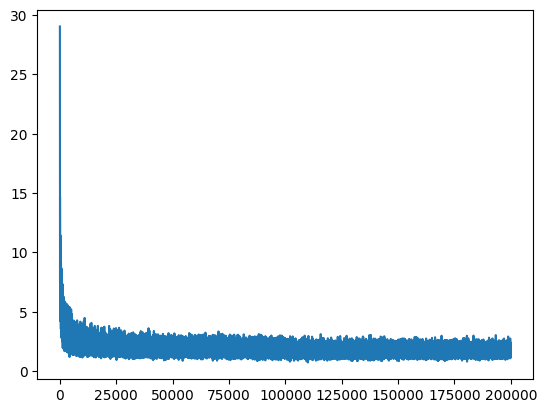

In [155]:
import matplotlib.pyplot as plt
plt.plot(lri, lossi)

In [156]:
# sample from the model
g = torch.Generator().manual_seed(13)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itow[i] for i in out))

him.
had.
wintsative.
your.
therens.
mr.
quverbt.
boloehid.
away.
which.
of.
manette.
and.
be.
shise.
awasa.
now.
his.
itwalm.
ofthite.


### Comparison : Part 2 v Part 1

The metrics for model loss and the time taken are much better this time around even with a larger number of iterations. Hence, this approach works much better than our earlier approach.
  
  
  
Part 1  
Summary:  
Model uses a probabilistic bigram model with a N tensor to make predictions  
Loss: 2.34

Part 2  
Summary:   
Model is more sophisticated with multiple layers of neurons and a technique of mini batch is introduced for efficiency  
Loss: 1.85

# Building Makemore : Part 3

### Initialization and tanh saturation issue

We observe a hockey stick like loss function forming. This issue can be handled by initializing our W and b better.

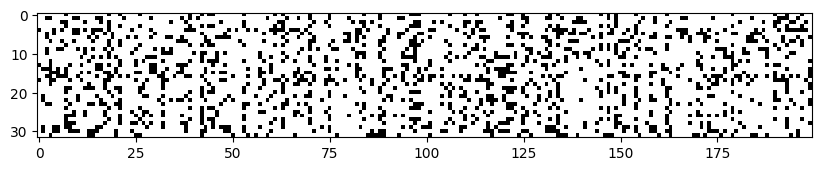

In [157]:
# forward pass
W1_test = W1.clone()
b1_test = b1.clone()

# create mini batch for input
mini_batch = torch.randint(0, Xtr.shape[0], (32,))
mini_batch_emb = C[Xtr[mini_batch]].view(-1,50)

# forward pass
layer1 = torch.tanh(mini_batch_emb @ W1_test + b1_test) # layer 1 # doesn't seem right to me as we're only pushing 32 examples here

# viz the graph
plt.figure(figsize = (10,20))
plt.imshow(layer1.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')


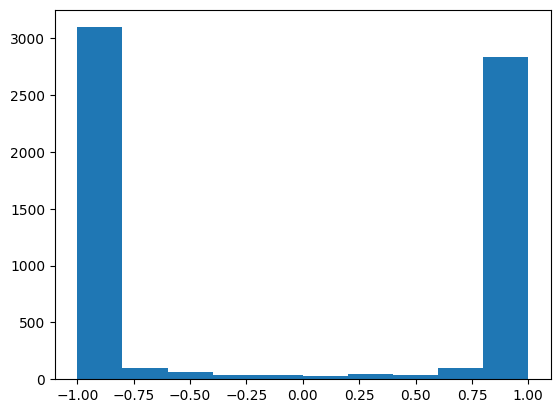

In [158]:
# tanh saturation
plt.hist(layer1.view(-1).detach());

With the histogram we can clearly see there are a lot of values which are greater than 0.99 or lesser than 0.99. These neurons would have the gradient as 0 and this would not contribute to our neural network. To fix this issue we will fix the intialization issue and then look at the distribution of our batches


### The fix


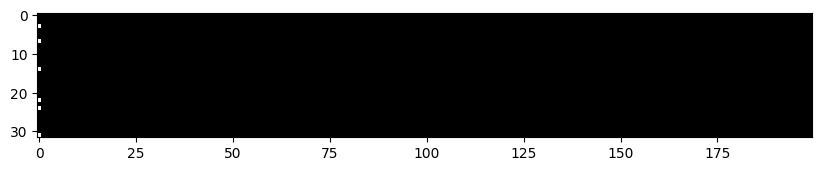

In [159]:
# forward pass
W1_test = W1.clone()
b1_test = b1.clone()

# create mini batch for input
mini_batch = torch.randint(0, Xtr.shape[0], (32,))
mini_batch_emb = C[Xtr[mini_batch]].view(-1,50)

# forward pass
layer1 = torch.tanh(mini_batch_emb @ W1_test.data.mul_(0.1) + b1_test.data.mul_(0)) # layer 1 # doesn't seem right to me as we're only pushing 32 examples here

# viz the graph
plt.figure(figsize = (10,20))
plt.imshow(layer1.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')


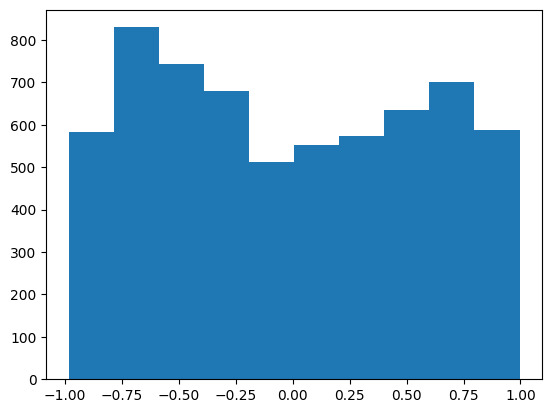

In [160]:
# check the distribution of the tanh function
plt.hist(layer1.view(-1).detach());

We've multiplied some numbers with the weights and biases to fix our tanh and initialization issue. Going forward the choice of these numbers cannot be arbitary. This was also one of the proposals of this paper. First let's see how well our training and test models perform

In [161]:
# C[Xtr[mini_batch]].shape
# torch.randint(0, Xtr.shape[0], (32,))

In [163]:
Xtr.shape

torch.Size([335776, 5])

In [164]:
# the code fix
# looping over the backward pass
g = torch.Generator().manual_seed(123)
emb_tr = C[Xtr]

# forward pass
W1 = torch.randn((50, 200), generator = g, requires_grad= True)
W1.data.mul_(0.1)
b1 = torch.randn(200,generator = g, requires_grad= True)
b1.data.mul_(0)
layer1 = torch.tanh(emb_tr.view(-1, 50) @ W1 + b1) # layer 1
W2 = torch.randn((200, 27), generator = g, requires_grad= True)
W2.data.mul_(0.01)
b2 = torch.randn(27, generator = g, requires_grad= True)
b2.data.mul_(0) # layer 2
layer2 = layer1 @ W2 + b2

# # create mini batch for input
# mini_batch = torch.randint(0, Xtr.shape[0], (32,))
# mini_batch_emb = C[Xtr[mini_batch]].view(-1,50)

# update params
parameters = [W1, W2, b1, b2]

# list declaration
lri = []
lossi = []
lr = 0.1


start_time = time.time()
# looping over
for i in range(200000):
  # create mini batch for input
  mini_batch = torch.randint(0, Xtr.shape[0], (32,))
  mini_batch_emb = C[Xtr[mini_batch]].view(-1,50)

  # forward pass
  # layer1 = torch.tanh(emb.view(-1, 50) @ W1 + b1) # layer 1
  layer1 = torch.tanh(mini_batch_emb @ W1 + b1) # layer 1 # doesn't seem right to me as we're only pushing 32 examples here
  layer2 = layer1 @ W2 + b2

  # loss function calculation
  loss = F.cross_entropy(layer2, Ytr[mini_batch])

  # resetting gradient to 0
  for p in parameters:
    p.grad = None  # recommended over .zero_() for performance

  # backward pass
  loss.backward()

  # updating this to see our learning rate iteration and loss iteration
  lri.append(i)
  lossi.append(loss.item())

  # update the neural network
  for param in parameters :
    lr = 0.1 if i < 100000 else 0.01
    param.data += -lr * param.grad

loss.item()

end_time = time.time()
final_time = end_time - start_time

print(f'The model took {final_time} seconds to run and the final loss is {loss.item()}')

The model took 129.04071497917175 seconds to run and the final loss is 1.587469458580017


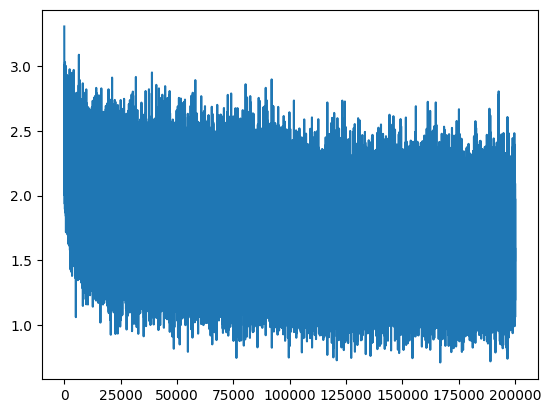

In [165]:
# viewing the loss function now
import matplotlib.pyplot as plt
plt.plot(lri, lossi)

In [166]:
# sample from the model
g = torch.Generator().manual_seed(13)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itow[i] for i in out))

his.
had.
with.
all.
four.
mannerhes.
mr.
queen.
wreverything.
he.
while.
of.
manette.
and.
be.
spidenceasantly.
his.
if.
almo.
other.


### Comparison : Part 1 v Part 2 v Part 3



In [ ]:
# first we normalize the W value based on fan in and then the batches
# if we do batchnorm then we don't need to work on W
# my neural net is leaky
# K says that he doesn't want it be gaussian always but just at initialization.
# to do so we apply this additional thing after normalization which is scale and shift
# karpathy fixes things at the end where he normalizes his testing set with a single mean and std
# removed b1 cz it made no sense to have it
# read resnet
# fix the fucking code
# it's bad
# maintain a log of the code
# understanding resnet
# conv layers are simply linear layers but as these are done on images they are like done in an overlapping manner
# for deep n/ws relu is better than
# what like how do we get rid of that hockey stick loss? can you come again pls
# there are a lot of things that can be added to its current state

In [ ]:
# LFG
# cover resnet in case you wish to
# Part 2 of this video is where the code is structured and it is cleansed and arranged in a class
# ok stopping here and recreating the code and structuring the notebook cz it feels it's long due now. need it for my mental clarity as well